Epoch 1/50
60/60 [==============================] - 25s 354ms/step - loss: 0.0241 - val_loss: 0.0058
Epoch 2/50
60/60 [==============================] - 21s 359ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 3/50
60/60 [==============================] - 20s 338ms/step - loss: 0.0070 - val_loss: 0.0063
Epoch 4/50
60/60 [==============================] - 20s 329ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 5/50
60/60 [==============================] - 19s 320ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 6/50
60/60 [==============================] - 19s 319ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 7/50
60/60 [==============================] - 19s 324ms/step - loss: 0.0061 - val_loss: 0.0054
Epoch 8/50
60/60 [==============================] - 20s 330ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 9/50
60/60 [==============================] - 19s 322ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 10/50
60/60 [==============================] - 19s 324ms/step - loss: 0.0057 - val_lo

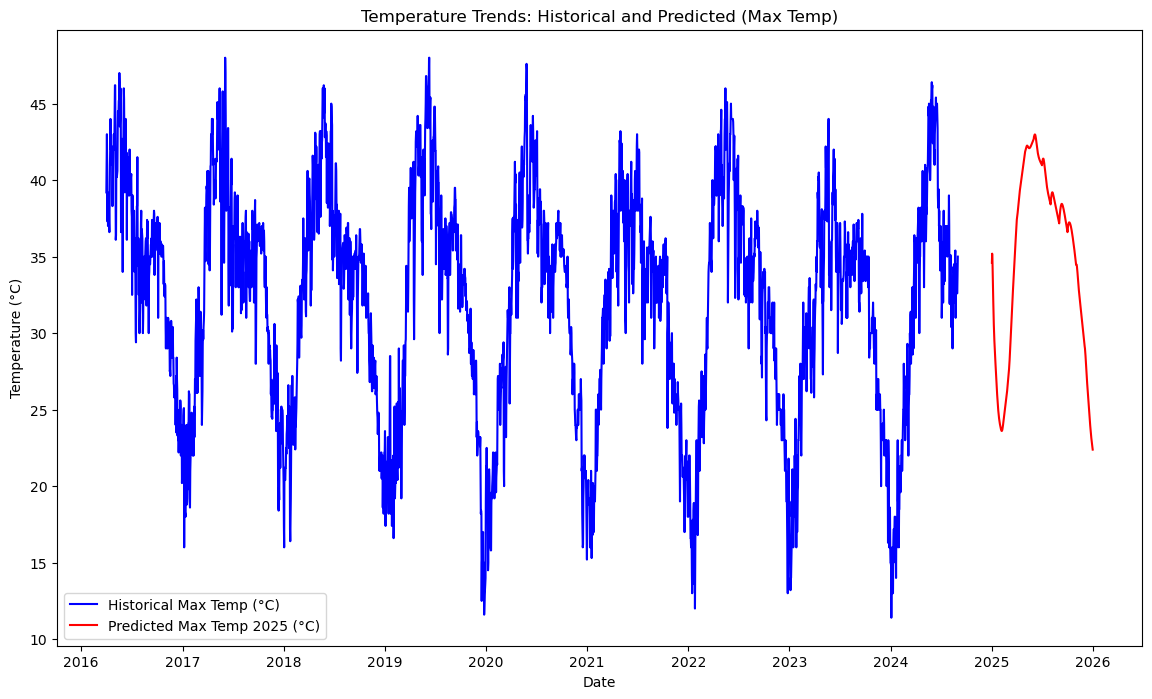

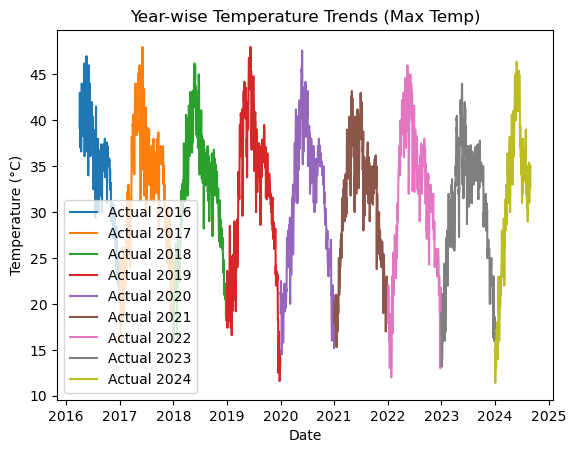

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
file_path = 'Delhi 2016 Weather data.xlsx'  # Replace with the actual path
df = pd.read_excel(file_path)

# Preprocess the dataset
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)

# Drop irrelevant columns and handle missing values
df = df.drop(columns=['snow', 'tsun'], errors='ignore')
df.fillna(method='ffill', inplace=True)

# Focus on the target variable: 'tmax' (maximum temperature)
temperature_data = df[['tmax']].copy()

# Add explicit seasonal and cyclic features
temperature_data['month_sin'] = np.sin(2 * np.pi * temperature_data.index.month / 12)
temperature_data['month_cos'] = np.cos(2 * np.pi * temperature_data.index.month / 12)
temperature_data['day_sin'] = np.sin(2 * np.pi * temperature_data.index.dayofyear / 365)
temperature_data['day_cos'] = np.cos(2 * np.pi * temperature_data.index.dayofyear / 365)

# Scale the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
temperature_data['tmax_scaled'] = scaler.fit_transform(temperature_data['tmax'].values.reshape(-1, 1))

# Prepare data for LSTM
sequence_length = 365  # Use a full year to capture seasonal patterns
X, y = [], []

for i in range(sequence_length, len(temperature_data)):
    past_data = temperature_data.iloc[i-sequence_length:i]
    X.append(past_data[['tmax_scaled', 'month_sin', 'month_cos', 'day_sin', 'day_cos']].values)
    y.append(temperature_data.iloc[i]['tmax_scaled'])

X, y = np.array(X), np.array(y)

# Split data into training, validation, and testing sets
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    batch_size=32, 
                    epochs=50, 
                    callbacks=[early_stopping])

# Predict for 2025
input_seq = X[-1:]  # Use the last sequence from the training data
future_predictions = []
future_dates = pd.date_range(start='2025-01-01', end='2025-12-31')

for _ in range(len(future_dates)):
    next_pred = model.predict(input_seq, verbose=0)
    future_predictions.append(next_pred[0, 0])
    
    # Create the next input sequence
    next_input = np.zeros((1, sequence_length, X_train.shape[2]))
    next_input[:, :-1, :] = input_seq[:, 1:, :]
    next_input[:, -1, 0] = next_pred[0, 0]
    next_input[:, -1, 1:] = [
        np.sin(2 * np.pi * future_dates[_].month / 12),
        np.cos(2 * np.pi * future_dates[_].month / 12),
        np.sin(2 * np.pi * future_dates[_].timetuple().tm_yday / 365),
        np.cos(2 * np.pi * future_dates[_].timetuple().tm_yday / 365)
    ]
    input_seq = next_input

# Scale back the predictions to the original temperature range
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Prepare the results DataFrame
predicted_temps = pd.DataFrame(data=future_predictions, index=future_dates, columns=['Predicted tmax'])

# Filter for June, July, and August of 2025
summer_2025 = predicted_temps[(predicted_temps.index.month.isin([6, 7, 8])) & (predicted_temps.index.year == 2025)]

# Display the predicted temperatures for June, July, and August 2025
print("Predicted Maximum Temperatures for June, July, and August 2025:")
print(summer_2025)

# Plot the predictions for all years
plt.figure(figsize=(14, 8))
plt.plot(temperature_data.index, temperature_data['tmax'], label='Historical Max Temp (°C)', color='blue')
plt.plot(predicted_temps.index, predicted_temps['Predicted tmax'], label='Predicted Max Temp 2025 (°C)', color='red')
plt.title('Temperature Trends: Historical and Predicted (Max Temp)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Year-wise plotting
for year in range(2016, 2025):
    if year == 2025:
        plt.plot(predicted_temps.index, predicted_temps['Predicted tmax'], label=f'Predicted {year}', linestyle='--')
    else:
        plt.plot(temperature_data[temperature_data.index.year == year].index,
                 temperature_data[temperature_data.index.year == year]['tmax'],
                 label=f'Actual {year}')
plt.title('Year-wise Temperature Trends (Max Temp)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on validation data
y_val_pred = model.predict(X_val)

# Calculate MAE, MSE, RMSE, and R²
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_val_pred)

print(f"Validation MAE: {mae}")
print(f"Validation MSE: {mse}")
print(f"Validation RMSE: {rmse}")
print(f"Validation R²: {r2}")

13/13 [==============================] - 1s 106ms/step
Validation MAE: 0.041492062758928826
Validation MSE: 0.0033895892488080832
Validation RMSE: 0.0582201790516663
Validation R²: 0.8970815755237871
